## Navigate to the Correct Directory

The following code navigates to the dataprocessing directory.

In [ ]:
cd ../dataprocessing

## Call the import statements

The following code imports the necessary code to run the code in the rest of this notebook.

In [ ]:
# import statements
import audio_processing as ap

import functools
import os
import sys
from absl import logging

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow import feature_column
from tensorflow.keras import layers
from matplotlib import pyplot as plt
import sklearn

# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format
# tf.keras.backend.set_floatx('float32')

print("Ran the import statements.")

In [ ]:
# set logging to print logging.INFO logs
logging.set_verbosity(logging.INFO)

In [ ]:
# arguments for audio_processing
src_dir = 'example_src_dir'
dest_dir = 'example_dest_dir'
filename = 'test_set2'
labels = ['Gunshot, gunfire']
available_features = ['chroma_stft',
                       'chroma_cqt',
                       'chroma_cens',
                       'melspectrogram',
                       'mfcc',
                       'rms',
                       'spectral_centroid',
                       'spectral_bandwidth',
                       'spectral_contrast',
                       'spectral_flatness',
                       'spectral_rolloff',
                       'poly_features',
                       'tonnetz',
                       'zero_crossing_rate'
]
features_to_extract = ['rms']

In [ ]:
# Import the dataset
df = ap.output_df(src_dir, dest_dir, filename, labels, features_to_extract, False)

In [ ]:
df.head()

In [ ]:
train_df_rms = df.copy()
train_df_rms.head()

In [ ]:
train_df_rms = train_df_rms.reindex(
    np.random.permutation(train_df_rms.index))
train_df_rms.head()

In [ ]:
# temp bug fix for rows with None features
# also deletes the outer array in the features
rows_with_none = []
print(train_df_rms.size / 2)
# print(train_df_rms.rms[0])
for i in train_df_rms.index:
    if train_df_rms.rms[i] is None:
        print('hey dum dum look at me', i)
        rows_with_none.append(i)
        continue
    train_df_rms.rms[i] = train_df_rms.rms[i][0]
print(rows_with_none)
train_df_rms = train_df_rms.drop(rows_with_none)
train_df_rms.size / 2
train_df_rms.head(10000)

In [ ]:
X = np.array(train_df_rms.rms.tolist(), dtype=object)
y = np.array(train_df_rms.label.tolist())

In [ ]:
# Temp bug fix for having different sized features
temp_x = []
temp_y = []
count = 0
for arr, label in zip(X, y):
    if arr is None or len(arr) < 431:
#         print('hey look at me', len(arr))
        count += 1
        continue
    temp_x.append(arr)
    temp_y.append(label)
X = np.array(temp_x, dtype=object)
y = np.array(temp_y)
print(count)

In [ ]:
# Define the plotting function.
def plot_curve(epochs, hist, list_of_metrics):
    """Plot a curve of one or more classification metrics vs. epoch."""  
    # list_of_metrics should be one of the names shown in:
    # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Value")

    for m in list_of_metrics:
        x = hist[m]
        plt.plot(epochs[1:], x[1:], label=m)

    plt.legend()
    return plt
    

print("Defined the plot_curve function.")

In [ ]:
x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(X, y, test_size=0.5, random_state = 42)

In [ ]:
# trying to fix bug:
# ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).
# It worked!!!
from keras import backend as K
x_train = K.cast_to_floatx(x_train)
y_train = K.cast_to_floatx(y_train)
x_val = K.cast_to_floatx(x_val)
y_val = K.cast_to_floatx(y_val)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
y_train = y_train.reshape(y_train.shape[0], 1)
x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
y_val = y_val.reshape(y_val.shape[0], 1)

In [ ]:
# print(x_train)
print(x_train.shape)

## Train 1
Convoluted Neural Network:
* Conv1D Layer 1:
* Flatten Layer 1: 
* Hidden Layer 2: 
* Ouput Layer: 1 node
Hyper-parameters:
* Loss Function: BinaryCrossEntropy
* Activation Function: Relu
* Optimizer Function: RMSprop
* Learning Rate: 0.001
* Epochs: 
* Batch_Size: 25
* Classification Threshold: 0.7
* Regularization: 
* Regularization Lambda: 

In [209]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv1D(filters=10, kernel_size=43, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_1'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    # Implement L2 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=20, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


In [ ]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 500
batch_size = 25
classification_threshold = 0.70
label_name = "label"

# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)
plot_curve(epochs, hist, ['loss', 'val_loss'])

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])

Model: "sequential_87"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 389, 10)           440       
_________________________________________________________________
Flatten_1 (Flatten)          (None, 3890)              0         
_________________________________________________________________
Hidden1 (Dense)              (None, 20)                77820     
_________________________________________________________________
Output (Dense)               (None, 1)                 21        
Total params: 78,281
Trainable params: 78,281
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
219/219 [==============================] - 2s 9ms/step - loss: 0.6872 - accuracy: 0.5395 - precision: 0.6949 - recall: 0.0320 - val_loss: 0.6686 - val_accuracy: 0.5652 - val_precision: 0.6842 - val_recall: 0.0886
Epoch 2/500
219/219 [=

219/219 [==============================] - 1s 6ms/step - loss: 0.6307 - accuracy: 0.5811 - precision: 0.7703 - recall: 0.1520 - val_loss: 0.6353 - val_accuracy: 0.5727 - val_precision: 0.7116 - val_recall: 0.1079
Epoch 34/500
219/219 [==============================] - 1s 6ms/step - loss: 0.6280 - accuracy: 0.5776 - precision: 0.7657 - recall: 0.1430 - val_loss: 0.6272 - val_accuracy: 0.5833 - val_precision: 0.7189 - val_recall: 0.1436
Epoch 35/500
219/219 [==============================] - 1s 6ms/step - loss: 0.6276 - accuracy: 0.5792 - precision: 0.7467 - recall: 0.1555 - val_loss: 0.6282 - val_accuracy: 0.5722 - val_precision: 0.7018 - val_recall: 0.1095
Epoch 36/500
219/219 [==============================] - 1s 6ms/step - loss: 0.6255 - accuracy: 0.5811 - precision: 0.7620 - recall: 0.1551 - val_loss: 0.6314 - val_accuracy: 0.5870 - val_precision: 0.7125 - val_recall: 0.1600
Epoch 37/500
219/219 [==============================] - 1s 6ms/step - loss: 0.6273 - accuracy: 0.5838 - preci

219/219 [==============================] - 1s 6ms/step - loss: 0.5912 - accuracy: 0.6351 - precision: 0.8191 - recall: 0.2848 - val_loss: 0.6802 - val_accuracy: 0.5956 - val_precision: 0.6955 - val_recall: 0.2034
Epoch 70/500
219/219 [==============================] - 1s 6ms/step - loss: 0.5894 - accuracy: 0.6322 - precision: 0.8115 - recall: 0.2809 - val_loss: 0.6721 - val_accuracy: 0.6033 - val_precision: 0.7031 - val_recall: 0.2270
Epoch 71/500
219/219 [==============================] - 1s 6ms/step - loss: 0.5870 - accuracy: 0.6375 - precision: 0.8120 - recall: 0.2953 - val_loss: 0.6719 - val_accuracy: 0.6013 - val_precision: 0.6837 - val_recall: 0.2359
Epoch 72/500
219/219 [==============================] - 1s 6ms/step - loss: 0.5875 - accuracy: 0.6404 - precision: 0.8193 - recall: 0.2992 - val_loss: 0.6649 - val_accuracy: 0.6106 - val_precision: 0.6756 - val_recall: 0.2832
Epoch 73/500
219/219 [==============================] - 1s 6ms/step - loss: 0.5838 - accuracy: 0.6448 - preci

219/219 [==============================] - 1s 6ms/step - loss: 0.5332 - accuracy: 0.7086 - precision: 0.8765 - recall: 0.4406 - val_loss: 0.7915 - val_accuracy: 0.6053 - val_precision: 0.6697 - val_recall: 0.2675
Epoch 106/500
219/219 [==============================] - 1s 6ms/step - loss: 0.5314 - accuracy: 0.7168 - precision: 0.8812 - recall: 0.4578 - val_loss: 0.7822 - val_accuracy: 0.6227 - val_precision: 0.6534 - val_recall: 0.3698
Epoch 107/500
219/219 [==============================] - 1s 6ms/step - loss: 0.5270 - accuracy: 0.7166 - precision: 0.8852 - recall: 0.4547 - val_loss: 0.7808 - val_accuracy: 0.6315 - val_precision: 0.6409 - val_recall: 0.4388
Epoch 108/500
219/219 [==============================] - 1s 6ms/step - loss: 0.5264 - accuracy: 0.7227 - precision: 0.8784 - recall: 0.4742 - val_loss: 0.7656 - val_accuracy: 0.6145 - val_precision: 0.6525 - val_recall: 0.3329
Epoch 109/500
219/219 [==============================] - 1s 6ms/step - loss: 0.5242 - accuracy: 0.7181 - p

219/219 [==============================] - 1s 6ms/step - loss: 0.4784 - accuracy: 0.7692 - precision: 0.9037 - recall: 0.5684 - val_loss: 0.9415 - val_accuracy: 0.5985 - val_precision: 0.6460 - val_recall: 0.2671
Epoch 142/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4762 - accuracy: 0.7674 - precision: 0.9077 - recall: 0.5609 - val_loss: 0.9378 - val_accuracy: 0.6101 - val_precision: 0.6449 - val_recall: 0.3249
Epoch 143/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4756 - accuracy: 0.7725 - precision: 0.9124 - recall: 0.5695 - val_loss: 0.9266 - val_accuracy: 0.6161 - val_precision: 0.6125 - val_recall: 0.4336
Epoch 144/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4768 - accuracy: 0.7771 - precision: 0.9112 - recall: 0.5813 - val_loss: 0.9896 - val_accuracy: 0.6081 - val_precision: 0.6470 - val_recall: 0.3117
Epoch 145/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4707 - accuracy: 0.7804 - p

219/219 [==============================] - 1s 6ms/step - loss: 0.4346 - accuracy: 0.8144 - precision: 0.9324 - recall: 0.6516 - val_loss: 1.0981 - val_accuracy: 0.6209 - val_precision: 0.6034 - val_recall: 0.4950
Epoch 178/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4310 - accuracy: 0.8146 - precision: 0.9393 - recall: 0.6465 - val_loss: 1.0747 - val_accuracy: 0.6088 - val_precision: 0.5950 - val_recall: 0.4485
Epoch 179/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4282 - accuracy: 0.8144 - precision: 0.9373 - recall: 0.6477 - val_loss: 1.1214 - val_accuracy: 0.6088 - val_precision: 0.5840 - val_recall: 0.4978
Epoch 180/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4308 - accuracy: 0.8208 - precision: 0.9313 - recall: 0.6672 - val_loss: 1.0884 - val_accuracy: 0.6002 - val_precision: 0.5919 - val_recall: 0.4003
Epoch 181/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4285 - accuracy: 0.8183 - p

219/219 [==============================] - 1s 6ms/step - loss: 0.4085 - accuracy: 0.8461 - precision: 0.9447 - recall: 0.7137 - val_loss: 1.3246 - val_accuracy: 0.5958 - val_precision: 0.6103 - val_recall: 0.3173
Epoch 214/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4025 - accuracy: 0.8434 - precision: 0.9442 - recall: 0.7078 - val_loss: 1.2836 - val_accuracy: 0.6082 - val_precision: 0.5820 - val_recall: 0.5038
Epoch 215/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4075 - accuracy: 0.8423 - precision: 0.9445 - recall: 0.7051 - val_loss: 1.2733 - val_accuracy: 0.6055 - val_precision: 0.5936 - val_recall: 0.4312
Epoch 216/500
219/219 [==============================] - 1s 6ms/step - loss: 0.4028 - accuracy: 0.8439 - precision: 0.9481 - recall: 0.7059 - val_loss: 1.3006 - val_accuracy: 0.5962 - val_precision: 0.5607 - val_recall: 0.5335
Epoch 217/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3991 - accuracy: 0.8481 - p

219/219 [==============================] - 1s 6ms/step - loss: 0.3858 - accuracy: 0.8652 - precision: 0.9542 - recall: 0.7484 - val_loss: 1.5462 - val_accuracy: 0.5925 - val_precision: 0.6100 - val_recall: 0.2980
Epoch 250/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3781 - accuracy: 0.8659 - precision: 0.9529 - recall: 0.7512 - val_loss: 1.4983 - val_accuracy: 0.5929 - val_precision: 0.5920 - val_recall: 0.3486
Epoch 251/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3797 - accuracy: 0.8679 - precision: 0.9536 - recall: 0.7551 - val_loss: 1.4160 - val_accuracy: 0.5976 - val_precision: 0.5857 - val_recall: 0.4055
Epoch 252/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3870 - accuracy: 0.8626 - precision: 0.9548 - recall: 0.7422 - val_loss: 1.4363 - val_accuracy: 0.6002 - val_precision: 0.5920 - val_recall: 0.3999
Epoch 253/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3795 - accuracy: 0.8655 - p

219/219 [==============================] - 1s 7ms/step - loss: 0.3635 - accuracy: 0.8782 - precision: 0.9588 - recall: 0.7734 - val_loss: 1.6184 - val_accuracy: 0.6016 - val_precision: 0.5749 - val_recall: 0.4898
Epoch 286/500
219/219 [==============================] - 2s 7ms/step - loss: 0.3697 - accuracy: 0.8778 - precision: 0.9584 - recall: 0.7730 - val_loss: 1.5616 - val_accuracy: 0.6024 - val_precision: 0.5872 - val_recall: 0.4348
Epoch 287/500
219/219 [==============================] - 2s 7ms/step - loss: 0.3625 - accuracy: 0.8853 - precision: 0.9600 - recall: 0.7883 - val_loss: 1.6936 - val_accuracy: 0.5971 - val_precision: 0.5967 - val_recall: 0.3626
Epoch 288/500
219/219 [==============================] - 2s 7ms/step - loss: 0.3658 - accuracy: 0.8769 - precision: 0.9578 - recall: 0.7715 - val_loss: 1.5386 - val_accuracy: 0.5984 - val_precision: 0.5757 - val_recall: 0.4577
Epoch 289/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3609 - accuracy: 0.8760 - p

219/219 [==============================] - 1s 6ms/step - loss: 0.3525 - accuracy: 0.8901 - precision: 0.9618 - recall: 0.7973 - val_loss: 1.6933 - val_accuracy: 0.5930 - val_precision: 0.5831 - val_recall: 0.3815
Epoch 322/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3518 - accuracy: 0.8903 - precision: 0.9632 - recall: 0.7965 - val_loss: 1.7105 - val_accuracy: 0.6086 - val_precision: 0.5988 - val_recall: 0.4328
Epoch 323/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3462 - accuracy: 0.8934 - precision: 0.9674 - recall: 0.7996 - val_loss: 1.6558 - val_accuracy: 0.5943 - val_precision: 0.5741 - val_recall: 0.4320
Epoch 324/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3530 - accuracy: 0.8912 - precision: 0.9628 - recall: 0.7988 - val_loss: 1.6524 - val_accuracy: 0.5945 - val_precision: 0.5613 - val_recall: 0.5126
Epoch 325/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3558 - accuracy: 0.8883 - p

219/219 [==============================] - 2s 7ms/step - loss: 0.3364 - accuracy: 0.8954 - precision: 0.9707 - recall: 0.8012 - val_loss: 1.7109 - val_accuracy: 0.5984 - val_precision: 0.5758 - val_recall: 0.4573
Epoch 358/500
219/219 [==============================] - 2s 7ms/step - loss: 0.3372 - accuracy: 0.9022 - precision: 0.9690 - recall: 0.8176 - val_loss: 1.6997 - val_accuracy: 0.5962 - val_precision: 0.5709 - val_recall: 0.4653
Epoch 359/500
219/219 [==============================] - 2s 7ms/step - loss: 0.3361 - accuracy: 0.9044 - precision: 0.9722 - recall: 0.8195 - val_loss: 1.7505 - val_accuracy: 0.5918 - val_precision: 0.5537 - val_recall: 0.5463
Epoch 360/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3388 - accuracy: 0.9013 - precision: 0.9711 - recall: 0.8137 - val_loss: 1.8209 - val_accuracy: 0.6009 - val_precision: 0.5975 - val_recall: 0.3859
Epoch 361/500
219/219 [==============================] - 1s 7ms/step - loss: 0.3398 - accuracy: 0.8967 - p

219/219 [==============================] - 1s 6ms/step - loss: 0.3298 - accuracy: 0.9024 - precision: 0.9703 - recall: 0.8168 - val_loss: 1.7714 - val_accuracy: 0.5971 - val_precision: 0.5768 - val_recall: 0.4412
Epoch 394/500
219/219 [==============================] - 1s 7ms/step - loss: 0.3237 - accuracy: 0.9104 - precision: 0.9730 - recall: 0.8320 - val_loss: 1.7905 - val_accuracy: 0.5963 - val_precision: 0.5730 - val_recall: 0.4549
Epoch 395/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3248 - accuracy: 0.9093 - precision: 0.9725 - recall: 0.8301 - val_loss: 1.8375 - val_accuracy: 0.5962 - val_precision: 0.5960 - val_recall: 0.3586
Epoch 396/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3243 - accuracy: 0.9057 - precision: 0.9758 - recall: 0.8191 - val_loss: 1.9696 - val_accuracy: 0.5930 - val_precision: 0.5808 - val_recall: 0.3907
Epoch 397/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3262 - accuracy: 0.9068 - p

219/219 [==============================] - 1s 6ms/step - loss: 0.3140 - accuracy: 0.9110 - precision: 0.9680 - recall: 0.8379 - val_loss: 1.8710 - val_accuracy: 0.6009 - val_precision: 0.5660 - val_recall: 0.5403
Epoch 430/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3144 - accuracy: 0.9165 - precision: 0.9764 - recall: 0.8422 - val_loss: 1.9627 - val_accuracy: 0.6013 - val_precision: 0.5641 - val_recall: 0.5576
Epoch 431/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3203 - accuracy: 0.9119 - precision: 0.9710 - recall: 0.8371 - val_loss: 1.8836 - val_accuracy: 0.5899 - val_precision: 0.5812 - val_recall: 0.3646
Epoch 432/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3185 - accuracy: 0.9115 - precision: 0.9731 - recall: 0.8344 - val_loss: 1.9803 - val_accuracy: 0.5914 - val_precision: 0.5933 - val_recall: 0.3341
Epoch 433/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3226 - accuracy: 0.9090 - p

219/219 [==============================] - 1s 6ms/step - loss: 0.3134 - accuracy: 0.9192 - precision: 0.9788 - recall: 0.8461 - val_loss: 1.9952 - val_accuracy: 0.6060 - val_precision: 0.5813 - val_recall: 0.4906
Epoch 466/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3191 - accuracy: 0.9157 - precision: 0.9764 - recall: 0.8406 - val_loss: 2.1260 - val_accuracy: 0.5943 - val_precision: 0.5884 - val_recall: 0.3710
Epoch 467/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3141 - accuracy: 0.9159 - precision: 0.9683 - recall: 0.8484 - val_loss: 2.3209 - val_accuracy: 0.5907 - val_precision: 0.6128 - val_recall: 0.2812
Epoch 468/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3111 - accuracy: 0.9210 - precision: 0.9754 - recall: 0.8531 - val_loss: 2.0184 - val_accuracy: 0.5962 - val_precision: 0.5972 - val_recall: 0.3550
Epoch 469/500
219/219 [==============================] - 1s 6ms/step - loss: 0.3142 - accuracy: 0.9157 - p

## Train 2
Convoluted Neural Network:
* Conv1D Layer 1:
* MaxPooling1D 1:
* Conv1D Layer 1:
* MaxPooling1D 1:
* Flatten Layer 1: 
* Hidden Layer 1: 
* Hidden Layer 2:
* Ouput Layer: 1 node
Hyper-parameters:
* Loss Function: BinaryCrossEntropy
* Activation Function: Relu
* Optimizer Function: RMSprop
* Learning Rate: 0.001
* Epochs: 
* Batch_Size: 25
* Classification Threshold: 0.7
* Regularization: L2
* Regularization Lambda: 

In [207]:
# Define the functions that create and train a model.
def create_model(my_learning_rate, my_metrics):
    """Create and compile a simple classification model."""
    # Discard any pre-existing version of the model.
    model = None

    # Most simple tf.keras models are sequential.
    model = tf.keras.models.Sequential()
              
    model.add(tf.keras.layers.Conv1D(filters=5, kernel_size=43, padding='valid',
                                  activation='relu', input_shape=(431, 1),
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Conv1D_1'))
    
    model.add(tf.keras.layers.MaxPooling1D(pool_size=20,
                                           strides=19,
                                           padding='valid',
                                           name='MaxPooling1D_1'))
    
    model.add(tf.keras.layers.Flatten(name='Flatten_1'))
    
    # Implement L1 regularization in the first hidden layer.
    model.add(tf.keras.layers.Dense(units=100, 
                                  activation='relu',
                                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                  name='Hidden1'))
    
#     # Implement L1 regularization in the second hidden layer.
#     model.add(tf.keras.layers.Dense(units=20, 
#                                   activation='relu',
#                                   kernel_regularizer=tf.keras.regularizers.l1(0.001),
#                                   name='Hidden2'))

    # Funnel the regression value through a sigmoid function.
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,),
                                  activation=tf.sigmoid,
                                  name='Output'))

    # Call the compile method to construct the layers into a model that
    # TensorFlow can execute.  Notice that we're using a different loss
    # function for classification than for regression.    
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),                                                   
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=my_metrics)

    return model        
              
def train_model(model, features, label, epochs, label_name,
                batch_size=None, my_validation_split=0.1,
                validation_data=None, shuffle=True):
    """Feed a dataset into the model in order to train it."""

    # The x parameter of tf.keras.Model.fit can be a list of arrays.
    history = model.fit(x=features, y=label, batch_size=batch_size,
                      epochs=epochs, shuffle=shuffle, validation_data=validation_data)

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # Isolate the classification metric for each epoch.
    hist = pd.DataFrame(history.history)

    return epochs, hist  

print("Defined the create_model and train_model functions.")  

Defined the create_model and train_model functions.


Model: "sequential_85"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv1D_1 (Conv1D)            (None, 389, 5)            220       
_________________________________________________________________
MaxPooling1D_1 (MaxPooling1D (None, 20, 5)             0         
_________________________________________________________________
Flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
Hidden1 (Dense)              (None, 100)               10100     
_________________________________________________________________
Output (Dense)               (None, 1)                 101       
Total params: 10,421
Trainable params: 10,421
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
219/219 [==============================] - 1s 7ms/step - loss: 0.7210 - accuracy: 0.5340 - precision: 0

Epoch 33/100
219/219 [==============================] - 1s 5ms/step - loss: 0.6064 - accuracy: 0.6193 - precision: 0.8051 - recall: 0.2484 - val_loss: 0.6523 - val_accuracy: 0.6694 - val_precision: 0.6855 - val_recall: 0.5098
Epoch 34/100
219/219 [==============================] - 1s 5ms/step - loss: 0.6059 - accuracy: 0.6228 - precision: 0.7951 - recall: 0.2637 - val_loss: 0.6157 - val_accuracy: 0.5938 - val_precision: 0.7778 - val_recall: 0.1544
Epoch 35/100
219/219 [==============================] - 1s 6ms/step - loss: 0.6041 - accuracy: 0.6184 - precision: 0.8030 - recall: 0.2469 - val_loss: 0.6200 - val_accuracy: 0.6046 - val_precision: 0.7840 - val_recall: 0.1849
Epoch 36/100
219/219 [==============================] - 1s 5ms/step - loss: 0.6037 - accuracy: 0.6256 - precision: 0.8201 - recall: 0.2582 - val_loss: 0.6355 - val_accuracy: 0.5929 - val_precision: 0.7812 - val_recall: 0.1504
Epoch 37/100
219/219 [==============================] - 1s 5ms/step - loss: 0.6032 - accuracy: 0

219/219 [==============================] - 1s 5ms/step - loss: 0.5790 - accuracy: 0.6593 - precision: 0.8405 - recall: 0.3375 - val_loss: 0.6317 - val_accuracy: 0.6139 - val_precision: 0.7810 - val_recall: 0.2146
Epoch 70/100
219/219 [==============================] - 1s 5ms/step - loss: 0.5799 - accuracy: 0.6615 - precision: 0.8497 - recall: 0.3379 - val_loss: 0.6342 - val_accuracy: 0.6527 - val_precision: 0.7360 - val_recall: 0.3734
Epoch 71/100
219/219 [==============================] - 1s 5ms/step - loss: 0.5796 - accuracy: 0.6604 - precision: 0.8454 - recall: 0.3375 - val_loss: 0.6347 - val_accuracy: 0.6101 - val_precision: 0.7716 - val_recall: 0.2074
Epoch 72/100
219/219 [==============================] - 1s 6ms/step - loss: 0.5785 - accuracy: 0.6589 - precision: 0.8476 - recall: 0.3324 - val_loss: 0.6517 - val_accuracy: 0.6718 - val_precision: 0.7049 - val_recall: 0.4838
Epoch 73/100
219/219 [==============================] - 1s 5ms/step - loss: 0.5761 - accuracy: 0.6714 - preci

<module 'matplotlib.pyplot' from '/Users/carverforbes/.pyenv/versions/3.7.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

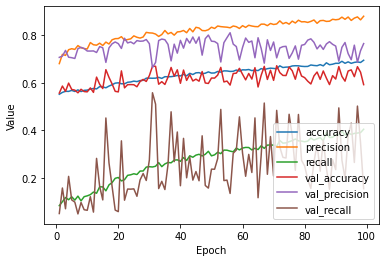

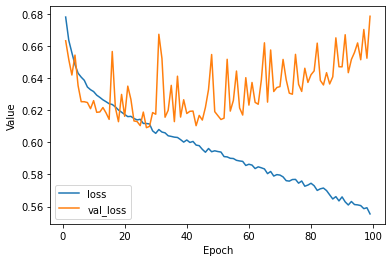

In [208]:
# The following variables are the hyperparameters.
learning_rate = 0.001
epochs = 100
batch_size = 25
classification_threshold = 0.70
label_name = "label"


# Here is the updated definition of METRICS:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(
          name='accuracy', threshold=classification_threshold),
      tf.keras.metrics.Precision(
          thresholds=classification_threshold, name='precision'),
      tf.keras.metrics.Recall(
          thresholds=classification_threshold, name="recall"),
]

# Establish the model's topography.
my_model = create_model(learning_rate, METRICS)

# View the model's structure.
my_model.summary()

# Train the model on the training set.
epochs, hist = train_model(my_model, x_train, y_train, epochs, 
                          label_name, batch_size, validation_data=(x_val, y_val))

# Plot metrics vs. epochs
list_of_metrics_to_plot = ['accuracy', "precision", "recall", 'val_accuracy', 'val_precision', 'val_recall'] 
plot_curve(epochs, hist, list_of_metrics_to_plot)
plot_curve(epochs, hist, ['loss', 'val_loss'])

training_performance =  my_model.evaluate(x_train, y_train, verbose=0)
print('Training Performance')
print('---------------------------------')
print('loss: ', training_performance[0])
print('accuracy: ', training_performance[1])
print('precision: ', training_performance[2])
print('recall: ', training_performance[3])
print()

validation_performance =  my_model.evaluate(x_val, y_val, verbose=0)
print('Validation Performance')
print('---------------------------------')
print('loss: ', validation_performance[0])
print('accuracy: ', validation_performance[1])
print('precision: ', validation_performance[2])
print('recall: ', validation_performance[3])